##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [1]:
!pip install -U -q tensorflow==2.16.1  tensorflow_datasets

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the Speech Commands dataset

This is the [dataset](https://dax-cdn.cdn.appdomain.cloud/dax-tensorflow-speech-commands/1.0.1/data_preview/index.html) that you will be working on. This dataset consists of 65,000 WAV Files and the audio clips were originally collected by Google, and recorded by volunteers in uncontrolled locations around the world.

In [81]:
DATASET_PATH = '/kaggle/input/tvd-2024-reconocimiento-de-comandos-de-voz/train/train/audio'

data_dir = pathlib.Path(DATASET_PATH)

The dataset's audio clips are stored in 31 folders corresponding to each speech command. 

- 20 core words: `yes`, `no`, `up`, `down`, `left`,`right`, `on`, `off`, `stop`, `go`, `zero`, `one`,`two`, `three`, `four`, `five`,`six`, `seven`, `eight`, `nine`,   

- 10 auxiliary words: `bed`, `bird`, `cat`, `dog`, `happy`, `house`, `marvin`, `sheila`, `tree` and `wow`
  
- And background noise: `doing_the_dishes`, `dude_miaowing`, `exercise_bike`, `pink_noise`, `running_tap`, and `white_noise`.

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['no' 'two' 'four' 'five' 'nine' 'right' '_background_noise_' 'off' 'yes'
 'six' 'dog' 'left' 'bird' 'wow' 'zero' 'eight' 'bed' 'go' 'house' 'tree'
 'seven' 'on' 'three' 'one' 'down' 'stop' 'up' 'happy' 'marvin' 'cat'
 'sheila']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`.

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [103]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 64727 files belonging to 31 classes.
Using 51782 files for training.
Using 12945 files for validation.

label names: ['_background_noise_' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five'
 'four' 'go' 'happy' 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one'
 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow'
 'yes' 'zero']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [6]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [104]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction.

In [105]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [9]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [10]:
label_names[[1,1,3,0]]

array(['bed', 'bed', 'cat', '_background_noise_'], dtype='<U18')

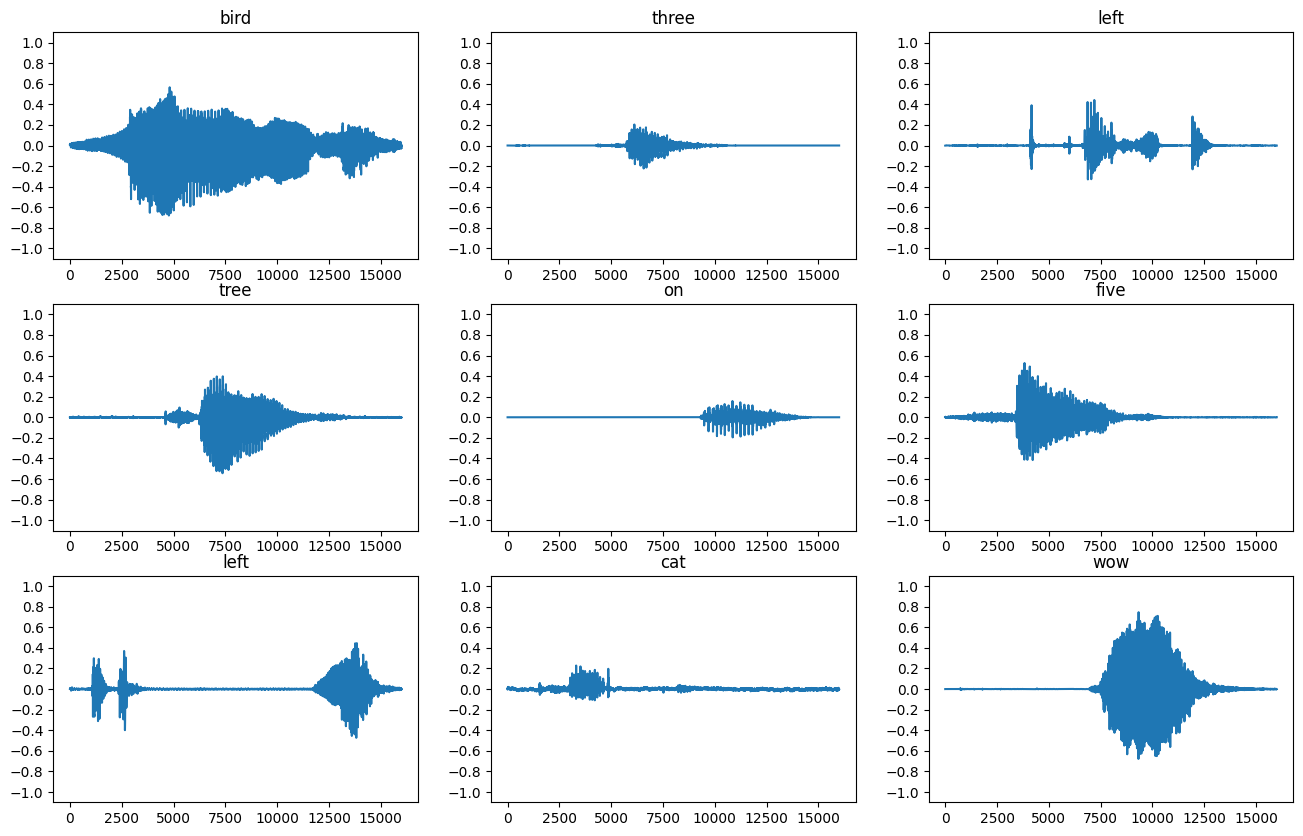

In [11]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [61]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram


def get_mel_spectrogram(waveform, num_mel_bins=128):
    # Compute the STFT.
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128
    )
    spectrogram = tf.abs(spectrogram)

    num_spectrogram_bins = spectrogram.shape[-1]

    
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=num_spectrogram_bins,
        sample_rate=16000,
        lower_edge_hertz=80.0, 
        upper_edge_hertz=8000.0)

    mel_spectrogram = tf.matmul(spectrogram, linear_to_mel_weight_matrix)
    mel_spectrogram = tf.math.log1p(mel_spectrogram)

    mel_spectrogram = mel_spectrogram[..., tf.newaxis]
    
    return mel_spectrogram

def get_mfcc(waveform, num_mel_bins=128, num_mfccs=13):
    log_mel_spectrogram = get_mel_spectrogram(waveform, num_mel_bins)
    
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(tf.squeeze(log_mel_spectrogram, axis=-1))

    mfccs = mfccs[..., :num_mfccs]  # Select the desired number of MFCCs
    mfccs = mfccs[..., tf.newaxis]
    return mfccs

def get_power_spectrogram(waveform):
    # Compute the STFT
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    # Compute the power spectrogram (squared magnitude)
    power_spectrogram = tf.square(tf.abs(spectrogram))
    power_spectrogram = power_spectrogram[..., tf.newaxis]
    return power_spectrogram



Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [13]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: bird
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: three
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [14]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

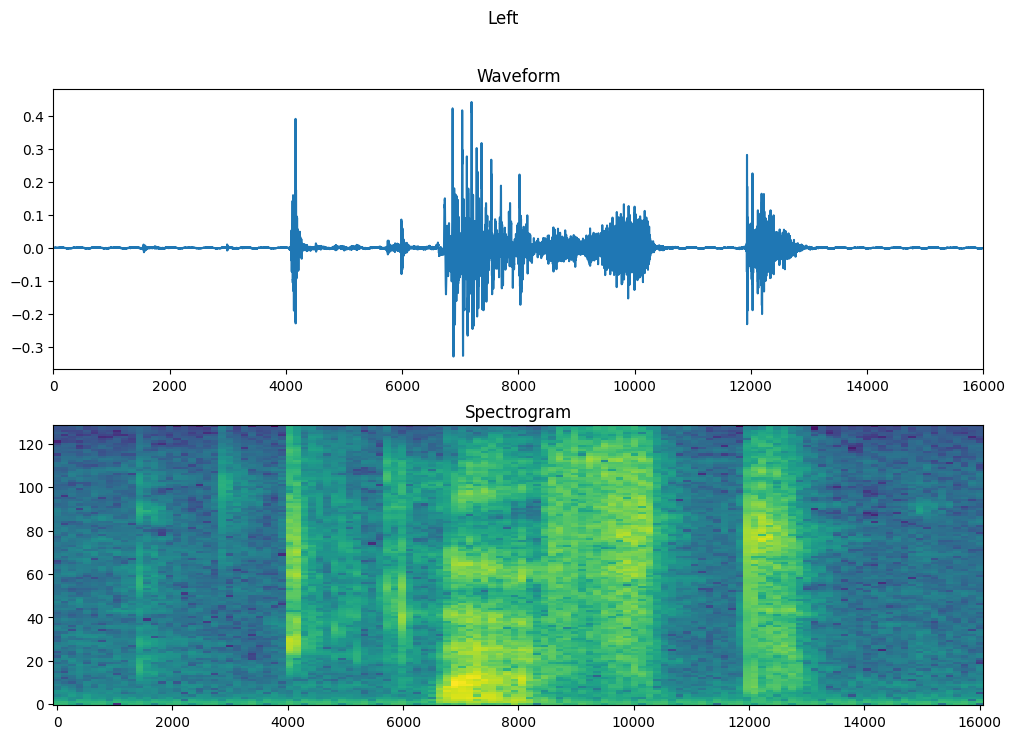

In [15]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [63]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)


def make_mel_ds(ds, bins=128):
  return ds.map(
      map_func=lambda audio,label: (get_mel_spectrogram(audio, bins), label),
      num_parallel_calls=tf.data.AUTOTUNE)

def make_mfcc_ds(ds, bins=128, mfcss=13):
  return ds.map(
      map_func=lambda audio,label: (get_mfcc(audio, bins, mfcss), label),
      num_parallel_calls=tf.data.AUTOTUNE)

def make_power_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_power_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

    

In [64]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [85]:
spectrogram_datasets = {
    'spectrogram': {
        'train': make_spec_ds(train_ds),
        'val': make_spec_ds(val_ds),
        'test': make_spec_ds(test_ds)
    },
    'power_spectrogram': {
        'train': make_power_ds(train_ds),
        'val': make_power_ds(val_ds),
        'test': make_power_ds(test_ds)
    },
    'mel_spectrogram_32': {
        'train': make_mel_ds(train_ds, bins=32),
        'val': make_mel_ds(val_ds, bins=32),
        'test': make_mel_ds(test_ds, bins=32)
    },
    'mel_spectrogram_64': {
        'train': make_mel_ds(train_ds, bins=64),
        'val': make_mel_ds(val_ds, bins=64),
        'test': make_mel_ds(test_ds, bins=64)
    },
    'mel_spectrogram_128': {
        'train': make_mel_ds(train_ds, bins=128),
        'val': make_mel_ds(val_ds, bins=128),
        'test': make_mel_ds(test_ds, bins=128)
    },
    'mfcc_13': {
        'train': make_mfcc_ds(train_ds, mfcss=13),
        'val': make_mfcc_ds(val_ds, mfcss=13),
        'test': make_mfcc_ds(test_ds, mfcss=13)
    },
    'mfcc_64_13': {
        'train': make_mfcc_ds(train_ds, bins=64, mfcss=13),
        'val': make_mfcc_ds(val_ds, bins=64, mfcss=13),
        'test': make_mfcc_ds(test_ds, bins=64, mfcss=13)
    },
    'mfcc_40': {
        'train': make_mfcc_ds(train_ds, mfcss=40),
        'val': make_mfcc_ds(val_ds, mfcss=40),
        'test': make_mfcc_ds(test_ds, mfcss=40)
    },
    'mfcc_64': {
        'train': make_mfcc_ds(train_ds, mfcss=64),
        'val': make_mfcc_ds(val_ds, mfcss=64),
        'test': make_mfcc_ds(test_ds, mfcss=64)
    },
    'mfcc_64_64': {
        'train': make_mfcc_ds(train_ds, bins=64, mfcss=64),
        'val': make_mfcc_ds(val_ds, bins=64, mfcss=64),
        'test': make_mfcc_ds(test_ds, bins=64, mfcss=64)
    }
}

## Build and train the model

In [96]:
from tensorflow.keras import layers, Sequential, regularizers

In [98]:
def build_and_train_model(train_ds, val_ds, input_shape, label_names, model_name):
    num_labels = len(label_names)

    # Instantiate the `tf.keras.layers.Normalization` layer.
    norm_layer = layers.Normalization()
    # Fit the state of the layer to the spectrograms
    # with `Normalization.adapt`.
    norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))

    model = Sequential([
        # Input preprocessing
        layers.Input(shape=input_shape),
        layers.Resizing(64, 64),
        norm_layer,
    
        # First Convolutional Block
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
    
        # Second Convolutional Block
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
    
        # Third Convolutional Block
        layers.Conv2D(256, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),
    
        # Fourth Convolutional Block
        layers.Conv2D(256, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),
    
        # Global Average Pooling for better generalization
        layers.GlobalAveragePooling2D(),
    
        # Dense Layers for classification
        layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.3),
    
        # Output layer with softmax activation for multi-class classification
        layers.Dense(num_labels),
    ])
    #model.summary()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )
    EPOCHS = 20
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=0,
        callbacks=tf.keras.callbacks.EarlyStopping(verbose=0, patience=10),
    )

    # Save the model
    model.save(f'{model_name}.h5')

    return history, model

Training with spectrogram...


I0000 00:00:1735408612.910611     102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1735408632.037223     105 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9570 - loss: 0.3047
Accuracy for spectrogram is 0.9573019742965698


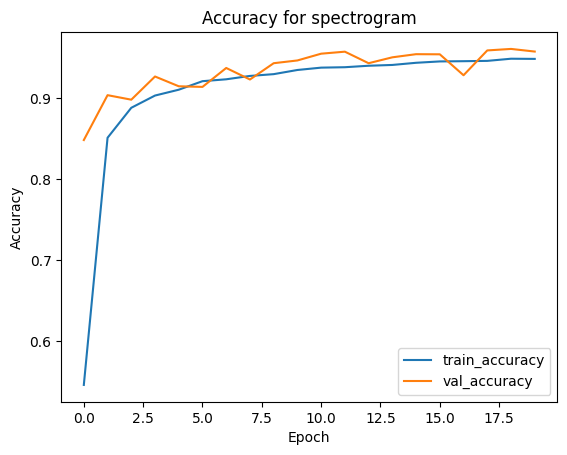

Training with power_spectrogram...
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8428 - loss: 0.7235
Accuracy for power_spectrogram is 0.844059407711029


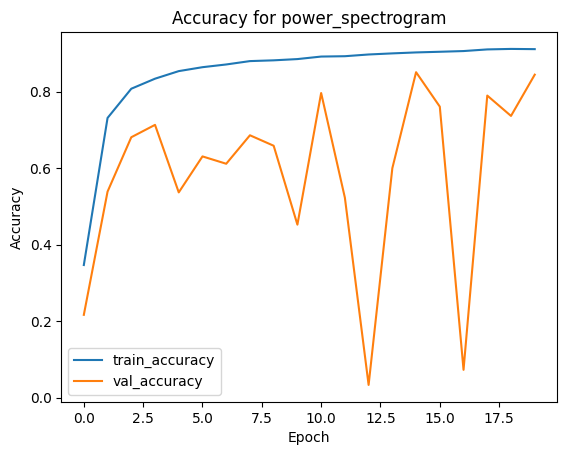

Training with mel_spectrogram_32...


I0000 00:00:1735409174.563019     103 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1735409191.087167     104 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9563 - loss: 0.3027
Accuracy for mel_spectrogram_32 is 0.9590036869049072


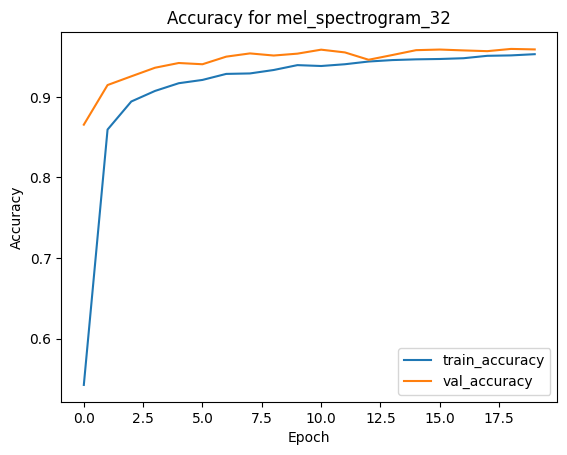

Training with mel_spectrogram_64...


I0000 00:00:1735409431.374945     102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1735409449.059413     102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9588 - loss: 0.2980
Accuracy for mel_spectrogram_64 is 0.9614789485931396


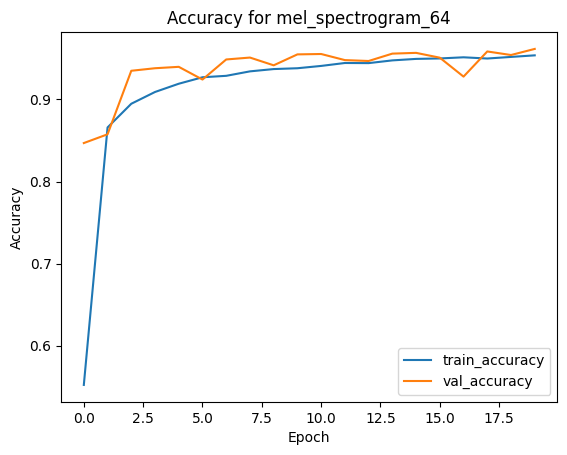

Training with mel_spectrogram_128...


I0000 00:00:1735409698.505985     105 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1735409710.973621     102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9585 - loss: 0.3016
Accuracy for mel_spectrogram_128 is 0.9603960514068604


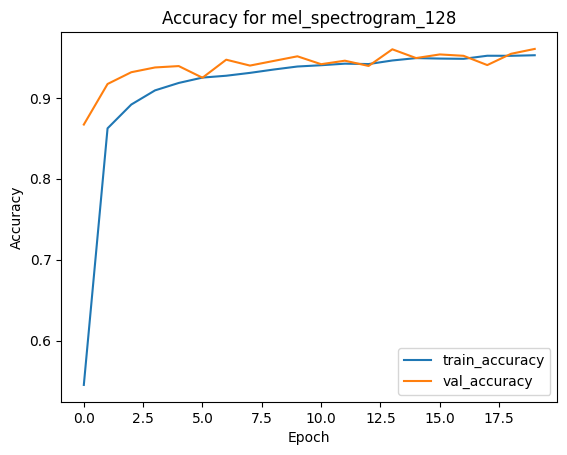

Training with mfcc_13...


I0000 00:00:1735409983.013203     103 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1735409992.798686     105 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9451 - loss: 0.3566
Accuracy for mfcc_13 is 0.9474009871482849


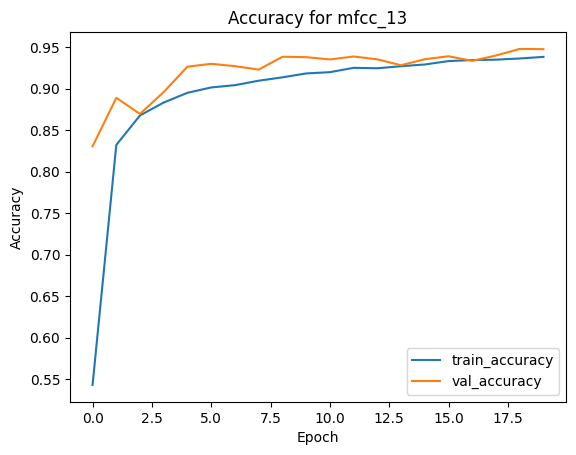

Training with mfcc_64_13...
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9388 - loss: 0.3764
Accuracy for mfcc_64_13 is 0.9439975023269653


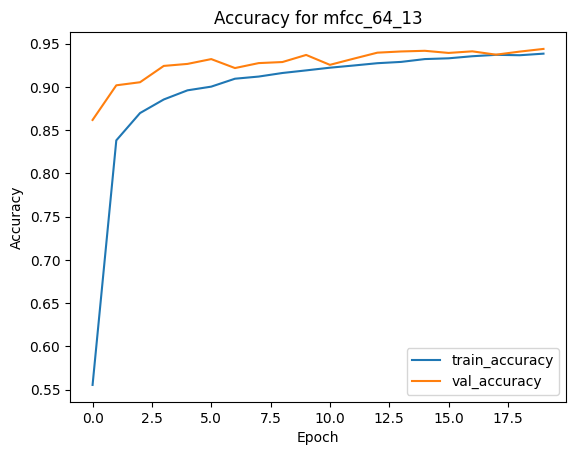

Training with mfcc_40...


I0000 00:00:1735410497.140556     102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1735410513.780423     103 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9487 - loss: 0.3385
Accuracy for mfcc_40 is 0.9514232873916626


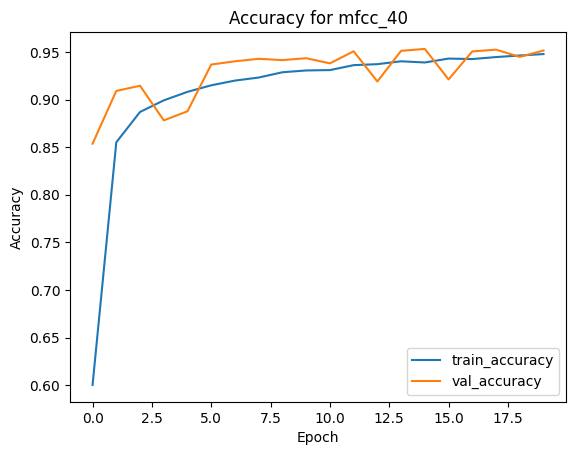

Training with mfcc_64...
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9477 - loss: 0.3412
Accuracy for mfcc_64 is 0.9494121074676514


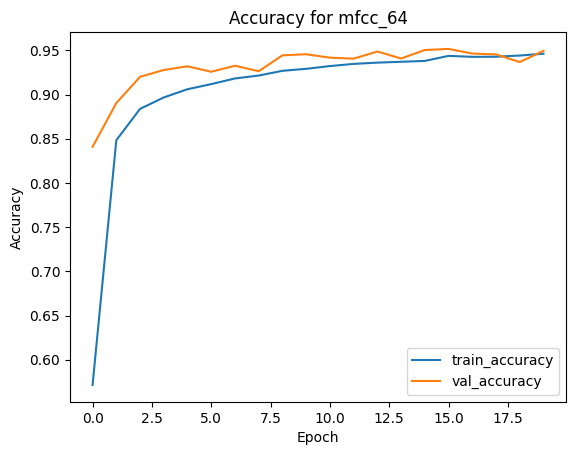

Training with mfcc_64_64...
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9535 - loss: 0.3259
Accuracy for mfcc_64_64 is 0.952815592288971


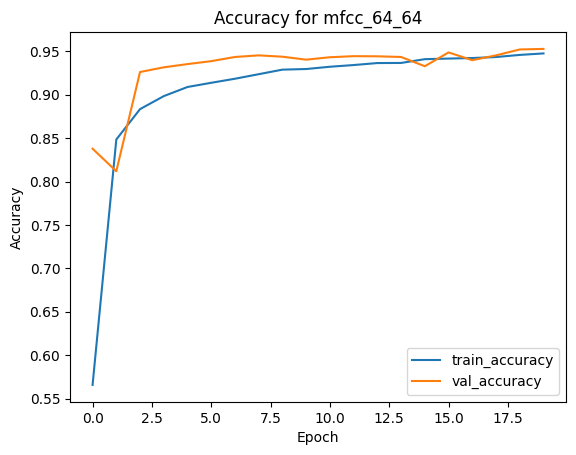


Training Results Summary:
- spectrogram:
  - Test Loss: 0.3008
  - Test Accuracy: 0.9573
- power_spectrogram:
  - Test Loss: 0.7212
  - Test Accuracy: 0.8441
- mel_spectrogram_32:
  - Test Loss: 0.2992
  - Test Accuracy: 0.9590
- mel_spectrogram_64:
  - Test Loss: 0.2961
  - Test Accuracy: 0.9615
- mel_spectrogram_128:
  - Test Loss: 0.2914
  - Test Accuracy: 0.9604
- mfcc_13:
  - Test Loss: 0.3495
  - Test Accuracy: 0.9474
- mfcc_64_13:
  - Test Loss: 0.3609
  - Test Accuracy: 0.9440
- mfcc_40:
  - Test Loss: 0.3262
  - Test Accuracy: 0.9514
- mfcc_64:
  - Test Loss: 0.3322
  - Test Accuracy: 0.9494
- mfcc_64_64:
  - Test Loss: 0.3195
  - Test Accuracy: 0.9528


In [99]:
import matplotlib.pyplot as plt
results = {}

for name, ds_dict in spectrogram_datasets.items():
    print(f"Training with {name}...")

    # Prepare the datasets
    train_ds = ds_dict['train'].cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
    val_ds = ds_dict['val'].cache().prefetch(tf.data.AUTOTUNE)
    test_ds = ds_dict['test'].cache().prefetch(tf.data.AUTOTUNE)

    # Get an example to determine input shape
    for example_spectrograms, example_spect_labels in train_ds.take(1):
        break
    input_shape = example_spectrograms.shape[1:]

    # Train the model
    history, model = build_and_train_model(train_ds, val_ds, input_shape, label_names, name)

    # Evaluate the model
    loss, accuracy = model.evaluate(val_ds)

    # Store the results
    results[name] = {
        'history': history.history,
        'test_loss': loss,
        'test_accuracy': accuracy
    }

    print(f"Accuracy for {name} is {accuracy}")

    # Plot accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'Accuracy for {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'{name}_accuracy.png')  # Save the plot
    plt.show()

# Print a summary of results
print("\nTraining Results Summary:")
for name, result in results.items():
    print(f"- {name}:")
    print(f"  - Test Loss: {result['test_loss']:.4f}")
    print(f"  - Test Accuracy: {result['test_accuracy']:.4f}")

In [93]:
import json

with open('results_spectrogram.json', 'w') as fp:
    json.dump(results, fp)


## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [133]:
model = tf.keras.models.load_model('mel_spectrogram_64.h5') 

In [125]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )

In [127]:
test_ds = spectrogram_datasets['mel_spectrogram_64']['test'].cache().prefetch(tf.data.AUTOTUNE)

In [119]:
test_spectrogram_ds = test_ds

In [115]:
test_spectrogram_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 124, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [134]:
model.evaluate(test_ds, return_dict=True)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2826 - loss: 2.9142


{'accuracy': 0.28776422142982483, 'loss': 2.900754928588867}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [35]:
y_pred = model.predict(test_spectrogram_ds)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [36]:
y_pred = tf.argmax(y_pred, axis=1)

In [37]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

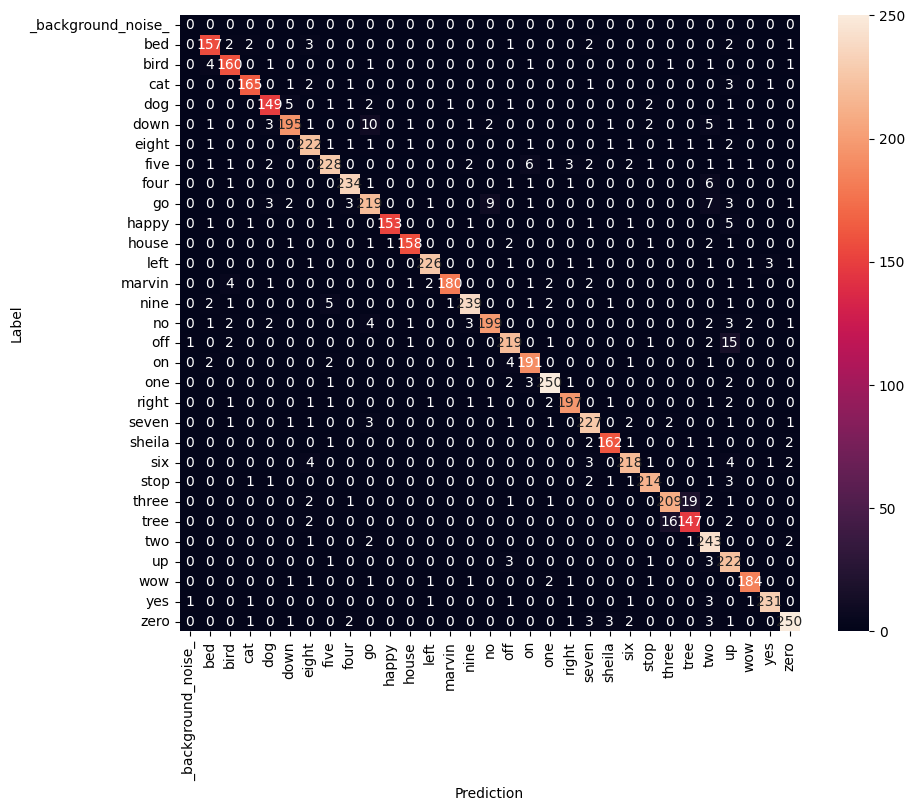

In [38]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Generate the submission file

The code below produces the `submission.csv` file, which you are required to submit for the competition. **Please do not make any changes in this cell**. 

In [39]:
import pandas as pd

l = [[i,j] for i,j in zip(list(range(1,len(y_pred)+1)), y_pred.numpy().tolist())]

df = pd.DataFrame(l, columns=['ID','labels'])

df.to_csv('submission.csv', index=False)